<a href="https://colab.research.google.com/github/jacobdwatters/NIOSH-Project/blob/main/SIG_SUB_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install scikit-plot imbalanced-learn scikeras[tensorflow] keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00


In [26]:
import numpy as np
from numpy.random import seed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from copy import deepcopy

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, make_scorer, roc_auc_score
from sklearn.metrics import r2_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, balanced_accuracy_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
import os
import inspect
import pickle
import lightgbm as lgb

import scikitplot as skplt

import scipy as sp
from scipy import stats
import seaborn as sns

import joblib
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.metrics import geometric_mean_score
import optuna

In [10]:
# from google.colab import drive
# drive.mount('/content/gdrive')
kt

NameError: name 'kt' is not defined

In [13]:
# path_after_2010 = '/content/gdrive/My Drive/NIOSH Project/data/violations_processed_after_2010.csv'
path_after_2010 = './after_2010.csv'
violation_data = pd.read_csv(path_after_2010)

In [15]:
violation_data.SIG_SUB.value_counts()

N    969911
Y    293086
Name: SIG_SUB, dtype: int64

In [16]:
FEATURES = ['PRIMARY_OR_MILL', 'COAL_METAL_IND', 'MINE_TYPE', 'VIOLATOR_TYPE_CD', 
            'VIOLATOR_INSPECTION_DAY_CNT', 'VIOLATOR_VIOLATION_CNT', 'YEAR_OCCUR']
TARGETS = ['SIG_SUB']

X = violation_data[FEATURES]
y = violation_data[TARGETS]
y['SIG_SUB'] = y['SIG_SUB'].map({"Y": 1, "N": 0})

col_names = X.columns

#X = X.to_numpy()
y = y.to_numpy().reshape((len(y),))

# X['MINE_TYPE'] = X['MINE_TYPE'].factorize()[0]
# X['COAL_METAL_IND'] = X['COAL_METAL_IND'].factorize()[0]

/tmp/ipykernel_23385/942335789.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['SIG_SUB'] = y['SIG_SUB'].map({"Y": 1, "N": 0})


In [17]:
X

,PRIMARY_OR_MILL,COAL_METAL_IND,MINE_TYPE,VIOLATOR_TYPE_CD,VIOLATOR_INSPECTION_DAY_CNT,VIOLATOR_VIOLATION_CNT,YEAR_OCCUR
0,Not_Applicable,C,Underground,Operator,2847.0,410.0,2011.0
1,Not_Applicable,C,Underground,Operator,596.0,365.0,2011.0
2,Not_Applicable,C,Surface,Operator,22.0,0.0,2011.0
3,Not_Applicable,C,Facility,Operator,11.0,0.0,2011.0
4,Primary,M,Facility,Operator,127.0,284.0,2011.0
...,...,...,...,...,...,...,...
1262992,Not_Applicable,C,Underground,Operator,552.0,179.0,2022.0
1262993,Not_Applicable,C,Underground,Operator,412.0,166.0,2021.0
1262994,Primary,M,Surface,Operator,170.0,217.0,2023.0
1262995,Primary,M,Surface,Operator,2.0,3.0,2022.0


In [18]:
y

array([0, 0, 1, ..., 1, 0, 0])

In [19]:
def encode_and_scale(X):

    # Define which columns should be encoded vs scaled
    columns_to_encode = ['PRIMARY_OR_MILL', 'COAL_METAL_IND', 'MINE_TYPE', 'VIOLATOR_TYPE_CD']
    columns_to_scale  = ['VIOLATOR_INSPECTION_DAY_CNT', 'VIOLATOR_VIOLATION_CNT', 'YEAR_OCCUR']

    # Instantiate encoder/scaler
    scaler = StandardScaler()
    ohe = OneHotEncoder(sparse=False)

    # Scale and Encode Separate Columns
    scaled_columns  = scaler.fit_transform(X[columns_to_scale])
    encoded_columns = ohe.fit_transform(X[columns_to_encode])

    # Concatenate (Column-Bind) Processed Columns Back Together
    X_pre = np.concatenate([scaled_columns, encoded_columns], axis=1)
    np.nan_to_num(X_pre, copy=False)

    cat_mask = np.array([False] * len(scaled_columns) + [True] * len(encoded_columns))

    return X_pre

# print('Features shape:', X_pre.shape)

full dataset = train, test

train = (model selection train), (model selection validation)

model selection train = (hyperparam train), (hyperparam validation)

full dataset = ((hyperparam train, hyperparam validation), model selection validation), test

Overall procedure:
```
X, y = get_data()
X_train, y_train, X_test, y_test = split(X, y)
X_train_model, y_train_model, X_test_model, y_test_model = split(X_train, y_train) 


results = {}
for model in models:
    # let function decide how to split data for best hyperparams
    select_best_hyperparams(model, hyperparam_options, X_train_model, y_train_model)
    model_results = model.eval(X_test_model, y_test_model)
    update_best(results, model, model_results)

final_model = best_results(results)


# no model has seen test data yet
model_eval = final_model.eval(X_test, y_test)
```



In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_train shape:', y_test.shape)

X_train shape: (947247, 7)
X_test shape: (315750, 7)
y_train shape: (947247,)
y_train shape: (315750,)


In [22]:
X_train

,PRIMARY_OR_MILL,COAL_METAL_IND,MINE_TYPE,VIOLATOR_TYPE_CD,VIOLATOR_INSPECTION_DAY_CNT,VIOLATOR_VIOLATION_CNT,YEAR_OCCUR
573260,Primary,M,Surface,Operator,42.0,33.0,2016.0
795896,Primary,M,Surface,Operator,3.0,4.0,2020.0
710161,Primary,M,Surface,Operator,3.0,19.0,2019.0
925294,Primary,M,Surface,Operator,3.0,4.0,2017.0
82689,Not_Applicable,C,Facility,Operator,257.0,171.0,2013.0
...,...,...,...,...,...,...,...
359783,Not_Applicable,C,Surface,Contractor,0.0,0.0,2013.0
152315,Not_Applicable,C,Surface,Operator,26.0,2.0,2013.0
963395,Mill,M,Surface,Operator,44.0,23.0,2017.0
117952,Not_Applicable,C,Underground,Operator,375.0,154.0,2012.0


In [24]:
smote_enc = SMOTENC(categorical_features=[0,1,2,3], n_jobs=-1)
X_train_res, y_train_res = smote_enc.fit_resample(X_train, y_train)

/home/zack/mambaforge/envs/general/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:572: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/zack/mambaforge/envs/general/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [29]:
smote_resampled_train = deepcopy(X_train_res)
smote_resampled_train['SIG_SUB'] = y_train_res
smote_resampled_train.to_csv('smote_resampled_train.csv', index=False)
unsampled_test = deepcopy(X_test)
unsampled_test['SIG_SUB'] = y_test
unsampled_test.to_csv('unsampled_test.csv', header=False)

In [73]:
def fact_df(df, cols=None):
    if cols == None:
        cols = ['PRIMARY_OR_MILL', 'COAL_METAL_IND', 'MINE_TYPE', 'VIOLATOR_TYPE_CD']
    cp = deepcopy(df)
    for col in cols:
        cp[col] = cp[col].factorize()[0]
    return cp

fact_df(X_train_res, ['PRIMARY_OR_MILL', 'COAL_METAL_IND', 'MINE_TYPE', 'VIOLATOR_TYPE_CD'])
#X_train_res.MINE_TYPE.factorize()[0]

,PRIMARY_OR_MILL,COAL_METAL_IND,MINE_TYPE,VIOLATOR_TYPE_CD,VIOLATOR_INSPECTION_DAY_CNT,VIOLATOR_VIOLATION_CNT,YEAR_OCCUR
0,0,0,0,0,42.00000,33.000000,2016.000000
1,0,0,0,0,3.00000,4.000000,2020.000000
2,0,0,0,0,3.00000,19.000000,2019.000000
3,0,0,0,0,3.00000,4.000000,2017.000000
4,1,1,1,0,257.00000,171.000000,2013.000000
...,...,...,...,...,...,...,...
1455041,1,1,2,0,138.70438,75.000000,2011.000000
1455042,1,1,1,0,27.00000,4.363581,2018.000000
1455043,0,0,0,0,5.00000,8.000000,2011.000000
1455044,2,0,2,1,0.00000,11.125340,2014.000000


In [56]:
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_train_res):
    print(y_train_res[train_index])

[0 0 1 ... 1 1 1]
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


In [81]:
pd.value_counts(y_train_res)

0    727523
1    727523
dtype: int64

In [84]:
def objective(trial):
    aucs = []
    kf = KFold(n_splits=5, shuffle=True)
    for train_index, test_index in kf.split(X_train_res):
        train_x, train_y = fact_df(X_train_res.iloc[train_index]), y_train_res[train_index]
        valid_x, valid_y = fact_df(X_train_res.iloc[test_index]), y_train_res[test_index]
        dtrain = lgb.Dataset(train_x, label=train_y)

        param = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }

        gbm = lgb.train(param, dtrain)
        preds = gbm.predict(valid_x)
        pred_labels = np.rint(preds)
        print(pd.value_counts(valid_y))
        auc = roc_auc_score(valid_y, pred_labels)
        aucs.append(auc)
    
    return np.mean(np.array(aucs))

In [85]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-03-28 23:00:48,555] A new study created in memory with name: no-name-792efab2-a29b-4aa8-a8b7-d4f65ca1d511


1    145537
0    145473
dtype: int64
1    145633
0    145376
dtype: int64
0    145613
1    145396
dtype: int64
0    145955
1    145054
dtype: int64


[I 2023-03-28 23:01:22,954] Trial 0 finished with value: 0.621738289451566 and parameters: {'lambda_l1': 1.1550445838450347, 'lambda_l2': 8.58972330975442e-08, 'num_leaves': 211, 'feature_fraction': 0.5967383922919892, 'bagging_fraction': 0.5487422552087983, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 0 with value: 0.621738289451566.


1    145903
0    145106
dtype: int64
0    145797
1    145213
dtype: int64
1    145772
0    145237
dtype: int64
0    145650
1    145359
dtype: int64
0    145535
1    145474
dtype: int64


[I 2023-03-28 23:01:49,653] Trial 1 finished with value: 0.6187799162146345 and parameters: {'lambda_l1': 4.5996643403278144e-07, 'lambda_l2': 1.6986587981290122e-06, 'num_leaves': 108, 'feature_fraction': 0.4973779832974733, 'bagging_fraction': 0.6301714578013691, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 0 with value: 0.621738289451566.


1    145705
0    145304
dtype: int64
1    145630
0    145380
dtype: int64
0    145842
1    145167
dtype: int64
0    145697
1    145312
dtype: int64
1    145634
0    145375
dtype: int64


[I 2023-03-28 23:02:10,360] Trial 2 finished with value: 0.6176361131114774 and parameters: {'lambda_l1': 0.003953315876249192, 'lambda_l2': 0.0683372810047654, 'num_leaves': 24, 'feature_fraction': 0.902209323820977, 'bagging_fraction': 0.6809907890938705, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 0 with value: 0.621738289451566.


1    145780
0    145229
dtype: int64
1    145538
0    145472
dtype: int64
1    145580
0    145429
dtype: int64
0    145807
1    145202
dtype: int64
1    145750
0    145259
dtype: int64


[I 2023-03-28 23:02:31,239] Trial 3 finished with value: 0.6240882338954544 and parameters: {'lambda_l1': 1.0003473210254108e-07, 'lambda_l2': 6.451681806121351e-05, 'num_leaves': 69, 'feature_fraction': 0.9154945505023173, 'bagging_fraction': 0.5477317820102812, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 3 with value: 0.6240882338954544.


0    145556
1    145453
dtype: int64
1    145506
0    145504
dtype: int64
1    145720
0    145289
dtype: int64
0    145745
1    145264
dtype: int64
1    145736
0    145273
dtype: int64


[I 2023-03-28 23:02:55,558] Trial 4 finished with value: 0.617382168901622 and parameters: {'lambda_l1': 0.056670204108836594, 'lambda_l2': 0.11108530708341223, 'num_leaves': 45, 'feature_fraction': 0.8021154797940635, 'bagging_fraction': 0.8438600366609392, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 3 with value: 0.6240882338954544.


0    145712
1    145297
dtype: int64
Number of finished trials: 5
Best trial:
  Value: 0.6240882338954544
  Params: 
    lambda_l1: 1.0003473210254108e-07
    lambda_l2: 6.451681806121351e-05
    num_leaves: 69
    feature_fraction: 0.9154945505023173
    bagging_fraction: 0.5477317820102812
    bagging_freq: 3
    min_child_samples: 16


In [86]:
dtrain = lgb.Dataset(fact_df(X_train_res), label=y_train_res)
param = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    'lambda_l1': 1.0003473210254108e-07,
    'lambda_l2': 6.451681806121351e-05,
    'num_leaves': 69,
    'feature_fraction': 0.9154945505023173,
    'bagging_fraction': 0.5477317820102812,
    'bagging_freq': 3,
    'min_child_samples': 16
}

gbm = lgb.train(param, dtrain)
preds = gbm.predict(fact_df(X_test))
pred_labels = np.rint(preds)
print(pd.value_counts(y_test))
auc = roc_auc_score(y_test, pred_labels)
print(auc)

0    242388
1     73362
dtype: int64
0.5444474638007208


In [101]:
gbm._feature_importnace

AttributeError: 'Booster' object has no attribute '_feature_importnace'

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

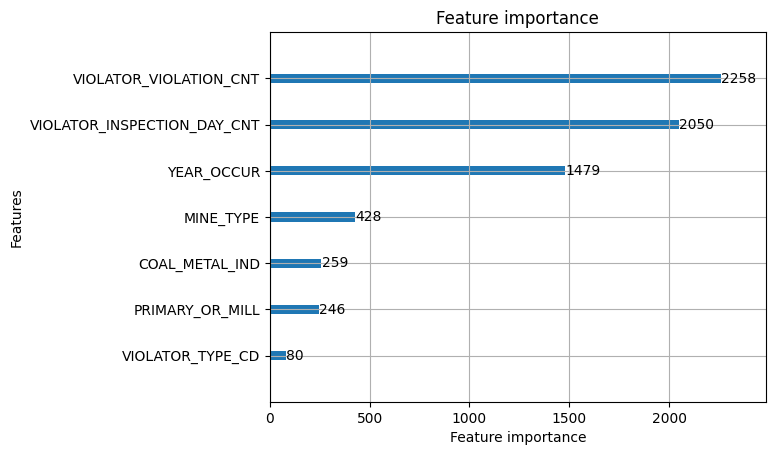

In [105]:
lgb.plot_importance(gbm, importance_type='split')

In [9]:
def specificity(y_pred, y_true):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    y_pred = keras.backend.round(y_pred)
    y_true = keras.backend.round(y_true)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = keras.backend.sum(neg_y_true * y_pred)
    tn = keras.backend.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + keras.backend.epsilon())
    return specificity

def sensitivity(y_pred, y_true):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    y_pred = keras.backend.round(y_pred)
    y_true = keras.backend.round(y_true)
    neg_y_pred = 1 - y_pred
    tp = keras.backend.sum(y_true * y_pred)
    fn = keras.backend.sum(neg_y_pred * y_true)
    sensitivity = tp / (tp + fn + keras.backend.epsilon())
    return sensitivity

def geometric_mean(y_pred, y_true):
    return keras.backend.sqrt(sensitivity(y_pred, y_true) * specificity(y_pred, y_true))

In [10]:
def split_data(data, indices):
    if isinstance(data, np.ndarray):
        return data[indices]
    elif pd is not None and isinstance(data, pd.DataFrame):
        return data.iloc[indices]
    else:
        raise TypeError()

class ModifiedSklearnTuner(kt.tuners.SklearnTuner):
    def run_trial(self, trial, X, y, sample_weight=None, groups=None):
        metrics = collections.defaultdict(list)
        # For cross-validation methods that expect a `groups` argument.
        cv_kwargs = {"groups": groups} if groups is not None else {}
        for train_indices, test_indices in self.cv.split(X, y, **cv_kwargs):
            X_train = split_data(X, train_indices)
            y_train = split_data(y, train_indices)
            X_test = split_data(X, test_indices)
            y_test = split_data(y, test_indices)

            # TODO SMOTE here
            X_train = encode_and_scale(X_train)
            X_test = encode_and_scale(X_test)

            sample_weight_train = (
                sample_weight[train_indices]
                if sample_weight is not None
                else None
            )

            model = self.hypermodel.build(trial.hyperparameters)

            supports_sw = (
                "sample_weight" in inspect.getfullargspec(model.fit).args
            )
            if isinstance(model, sklearn.pipeline.Pipeline) or not supports_sw:
                model.fit(X_train, y_train)
            else:
                model.fit(X_train, y_train, sample_weight=sample_weight_train)

            sample_weight_test = (
                sample_weight[test_indices]
                if sample_weight is not None
                else None
            )

            if self.scoring is None:
                score = model.score(
                    X_test, y_test, sample_weight=sample_weight_test
                )
            else:
                score = self.scoring(
                    model, X_test, y_test, sample_weight=sample_weight_test
                )
            metrics["score"].append(score)

            if self.metrics:
                y_test_pred = model.predict(X_test)
                for metric in self.metrics:
                    result = metric(
                        y_test, y_test_pred, sample_weight=sample_weight_test
                    )
                    metrics[metric.__name__].append(result)

        self.save_model(trial.trial_id, model)
        return {name: np.mean(values) for name, values in metrics.items()}
    
class BoostTuner(kt.tuners.SklearnTuner):
    def run_trial(self, trial, data, sample_weight=None, groups=None):
        metrics = collections.defaultdict(list)
        # For cross-validation methods that expect a `groups` argument.
        cv_kwargs = {"groups": groups} if groups is not None else {}
        for train_indices, test_indices in self.cv.split(X, y, **cv_kwargs):
            X_train = split_data(X, train_indices)
            y_train = split_data(y, train_indices)
            X_test = split_data(X, test_indices)
            y_test = split_data(y, test_indices)

            # TODO SMOTE here
            X_train = encode_and_scale(X_train)
            X_test = encode_and_scale(X_test)

            sample_weight_train = (
                sample_weight[train_indices]
                if sample_weight is not None
                else None
            )

            model = self.hypermodel.build(trial.hyperparameters)

            supports_sw = (
                "sample_weight" in inspect.getfullargspec(model.fit).args
            )
            if isinstance(model, sklearn.pipeline.Pipeline) or not supports_sw:
                model.fit(X_train, y_train)
            else:
                model.fit(X_train, y_train, sample_weight=sample_weight_train)

            sample_weight_test = (
                sample_weight[test_indices]
                if sample_weight is not None
                else None
            )

            if self.scoring is None:
                score = model.score(
                    X_test, y_test, sample_weight=sample_weight_test
                )
            else:
                score = self.scoring(
                    model, X_test, y_test, sample_weight=sample_weight_test
                )
            metrics["score"].append(score)

            if self.metrics:
                y_test_pred = model.predict(X_test)
                for metric in self.metrics:
                    result = metric(
                        y_test, y_test_pred, sample_weight=sample_weight_test
                    )
                    metrics[metric.__name__].append(result)

        self.save_model(trial.trial_id, model)
        return {name: np.mean(values) for name, values in metrics.items()}



In [87]:
model_input_shape = encode_and_scale(X_test)[0].shape

batch_size = 2**14
epochs = 120

class NNSigClassifierHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.Input(shape=model_input_shape))
        for hidden_layer_num in range(hp.Int("num_layers", min_value=2, max_value=10)):
            model.add(layers.Dense(units=hp.Int(f"units_{hidden_layer_num}", min_value=4, max_value=128)))
        model.add(layers.Dense(1, activation="sigmoid"))
        model.compile(loss=BinaryCrossentropy(), 
                      optimizer="adam", 
                      metrics=[keras.metrics.AUC()])
        return model
    
    def fit(self, hp, model, x, y, **kwargs):
        if True: #hp.Boolean("smote"):
            smote_nc = RandomOverSampler() #SMOTENC(categorical_features=[0, 1], random_state=0)
            x, y = smote_nc.fit_resample(x, y)
        x = encode_and_scale(x)
        return model.fit(x, y, batch_size=batch_size, **kwargs)

nn_tuner = kt.Hyperband(hypermodel=NNSigClassifierHyperModel(),
                           objective=kt.Objective('val_auc', 'max'),
                           max_epochs=20,
                           overwrite=True)

class ForestSigClassifierHyperModel(kt.HyperModel):
    def build(self, hp):
        model = RandomForestClassifier(n_estimators=hp.Int('n_estimators', 25, 150, step=25,),
                                       max_depth=hp.Int('max_depth', 3, 10))
        return model

    def fit(self, hp, model, x, y, **kwargs):
        if True: #hp.Boolean("smote"):
            smote_nc = RandomOverSampler() #SMOTENC(categorical_features=[0, 1], random_state=0)
            x, y = smote_nc.fit_resample(x, y)
        x = encode_and_scale(x)
        return model.fit(x, y, **kwargs)

forest_tuner = ModifiedSklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=10
    ),
    hypermodel=ForestSigClassifierHyperModel(),
    scoring=make_scorer(roc_auc_score, needs_proba=True),
    cv=StratifiedKFold(5),
    overwrite=True
)

class BoostSigClassifierHyperModel(kt.HyperModel):
    def build(self, hp):
        model = lgb.LGBMClassifier(
                                  num_leaves=hp.Int('num_leaves', 20, 80),
                                  n_estimators=hp.Int('n_estimators', 70, 250),
                                  random_state=0)
        return model

    def fit(self, hp, model, x, y, **kwargs):
        
        if True: #hp.Boolean("smote"):
            smote_nc = RandomOverSampler() #SMOTENC(categorical_features=[0, 1], random_state=0)
            x, y = smote_nc.fit_resample(x, y)
        x = encode_and_scale(x)
        return model.fit(x, y, **kwargs)

boost_tuner = ModifiedSklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=20
    ),
    hypermodel=BoostSigClassifierHyperModel(),
    scoring=make_scorer(roc_auc_score, needs_proba=True),
    cv=StratifiedKFold(5),
    overwrite=True
)

In [88]:
tuners = [boost_tuner, nn_tuner, forest_tuner]

X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)

for tuner in tuners:
    if isinstance(tuner, kt.Hyperband):
        X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(X_train_model, y_train_model, test_size = 0.25, random_state = 0)
        tuner.search(X_train_hp, y_train_hp, validation_data=(encode_and_scale(X_test_hp), y_test_hp))
    else:
        # CV automatically done
        tuner.search(X_train_model, y_train_model)

Trial 10 Complete [02h 16m 30s]
score: 0.5520304706949168

Best score So Far: 0.5522688511927905
Total elapsed time: 02h 48m 14s
INFO:tensorflow:Oracle triggered exit


In [97]:
make_scorer(roc_auc_score, needs_proba=True)()

TypeError: __call__() missing 3 required positional arguments: 'estimator', 'X', and 'y_true'

In [100]:
# compare models
tuner_names = {
    'neural_net': nn_tuner,
    'random_forest': forest_tuner,
    'boost': boost_tuner
}

best_models = {}
scores = {}

for name, tuner in tuner_names.items():
    print(f'Best hyperparams for {name}:\n{tuner.get_best_hyperparameters()[0].values}\n\n')
    best_models[name] = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
    if name == 'neural_net':
        X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_model, y_train_model, test_size = 0.25, random_state = 0)
        history = best_models[name].fit(encode_and_scale(X_train_nn), y_train_nn, epochs=epochs, batch_size=batch_size, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_data=(encode_and_scale(X_val_nn), y_val_nn))
        loss, auc = best_models[name].evaluate(encode_and_scale(X_test_model), y_test_model)
        scores[name] = auc
    else:
        best_models[name].fit(encode_and_scale(X_train_model), y_train_model)
        scores[name] = make_scorer(roc_auc_score, needs_proba=True)(best_models[name], encode_and_scale(X_test_model), y_test_model)

Best hyperparams for neural_net:
{'num_layers': 2, 'units_0': 115, 'units_1': 109, 'units_2': 54, 'units_3': 69, 'units_4': 33, 'units_5': 61, 'units_6': 101, 'units_7': 69, 'units_8': 30, 'units_9': 71, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0021'}


Epoch 1/120
37/37 [==============================] - 2s 26ms/step - loss: 0.5696 - auc_3: 0.5035 - val_loss: 0.5498 - val_auc_3: 0.5184
Epoch 2/120
37/37 [==============================] - 1s 17ms/step - loss: 0.5505 - auc_3: 0.5200 - val_loss: 0.5494 - val_auc_3: 0.5209
Epoch 3/120
37/37 [==============================] - 1s 16ms/step - loss: 0.5503 - auc_3: 0.5222 - val_loss: 0.5495 - val_auc_3: 0.5222
Epoch 4/120
37/37 [==============================] - 1s 16ms/step - loss: 0.5504 - auc_3: 0.5204 - val_loss: 0.5495 - val_auc_3: 0.5198
Epoch 5/120
8374/8374 [==============================] - 13s 2ms/step - loss: 0.5494 - auc_3: 0.5188
Best hyperparams for random_forest:
{'n

In [103]:
print(scores)

best_model = tuner_names['boost'].hypermodel.build(tuner_names['boost'].get_best_hyperparameters()[0])
best_model.fit(encode_and_scale(X_train), y_train)
auc = make_scorer(roc_auc_score, needs_proba=True)(best_model, encode_and_scale(X_test), y_test)
print(f'Boost AUC: {auc}')

{'neural_net': 0.518781304359436, 'random_forest': 0.555923932305043, 'boost': 0.5602131942157936}
Boost AUC: 0.564029617959722


In [68]:
batch_size = 2**14
epochs = 120


def make_dnn_model(n_layers=5):
    model = keras.Sequential()

    model.add(keras.Input(shape = model_input_shape ))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(8, activation="relu"))
    model.add(layers.Dense(8, activation="relu"))
    model.add(layers.Dense(8, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

# X_train_res, y_train_res = oversampler.fit_resample(X_train, y_train)
# print(f'Shapes: \nX_train_res: {X_train_res.shape}\ny_train_res: {y_train_res.shape}')

model_unbalanced = make_dnn_model()
# model_balanced = make_dnn_model()




opt_unbalanced = keras.optimizers.Adam(learning_rate=0.01)
model_unbalanced.compile(loss=BinaryCrossentropy(), optimizer=opt_unbalanced,
                    metrics=[geometric_mean])
history_unbalanced = model_unbalanced.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_data=(X_test, y_test))

# opt_balanced = keras.optimizers.Adam(learning_rate=0.01)
# model_balanced.compile(loss=BinaryCrossentropy(), optimizer=opt_balanced)
# history_balanced = model_balanced.fit(X_train_res, y_train_res, epochs=epochs, batch_size=batch_size, 
#                     callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_data=(X_test, y_test))

Epoch 1/120
66/66 [==============================] - 2s 20ms/step - loss: 0.5672 - geometric_mean: 0.4273 - val_loss: 0.5507 - val_geometric_mean: 0.4283
Epoch 2/120
66/66 [==============================] - 1s 18ms/step - loss: 0.5496 - geometric_mean: 0.4281 - val_loss: 0.5503 - val_geometric_mean: 0.4287
Epoch 3/120
66/66 [==============================] - 1s 17ms/step - loss: 0.5493 - geometric_mean: 0.4284 - val_loss: 0.5500 - val_geometric_mean: 0.4290
Epoch 4/120
66/66 [==============================] - 2s 26ms/step - loss: 0.5491 - geometric_mean: 0.4287 - val_loss: 0.5498 - val_geometric_mean: 0.4293
Epoch 5/120
66/66 [==============================] - 2s 26ms/step - loss: 0.5490 - geometric_mean: 0.4290 - val_loss: 0.5498 - val_geometric_mean: 0.4294
Epoch 6/120
66/66 [==============================] - 1s 18ms/step - loss: 0.5489 - geometric_mean: 0.4291 - val_loss: 0.5496 - val_geometric_mean: 0.4297
Epoch 7/120
66/66 [==============================] - 1s 17ms/step - loss: 0.

In [59]:
y1 = tf.convert_to_tensor(np.array([0.2,0,0.7,1,0], dtype=float))
y2 = tf.convert_to_tensor(np.array([1,1,1,1,0], dtype=float))

#geometric_mean(y1, y2)
#keras.backend.sqrt(specificity(y1,y2) * sensitivity(y1,y2))

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 1., 0.], dtype=float32)>

11166/11166 [==============================] - 20s 2ms/step


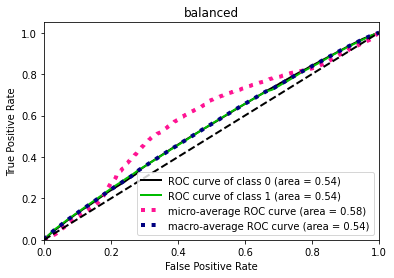

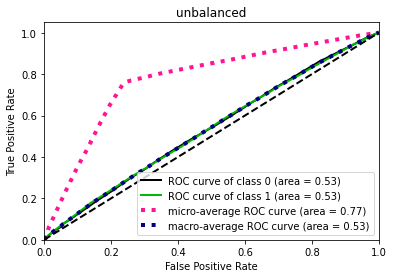

In [17]:
models = {'balanced': model_balanced, 'unbalanced': model_unbalanced}

for model_name, model in models.items():
    y_prob = model.predict(X_test)
    y_pred = y_prob > 0.5
    y_probs = np.column_stack([1-y_prob, y_prob])
    skplt.metrics.plot_roc(y_test.flatten(), y_probs, title=model_name)

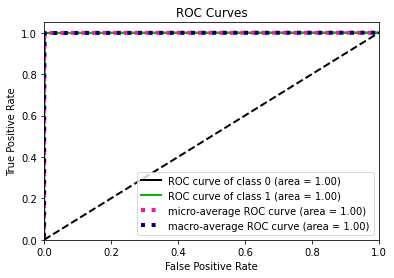

In [ ]:
skplt.metrics.plot_roc(y_test.to_numpy().flatten(), y_probs)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
count_sig = sum(y_test.to_numpy()).item()
count_non_sig = len(y_test) - count_sig
print(f'Portion SIG_SUB: {count_sig / len(y_test) * 100:.2f}%')
print(f'Portion non-SIG_SUB: {count_non_sig / len(y_test) * 100:.2f}%')
print(f'Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')

Portion SIG_SUB: 24.01%
Portion non-SIG_SUB: 75.99%
Accuracy: 0.998558569653273
Precision: 0.9962640969239901
Recall: 0.997738822322719
F1: 0.9970009142843833


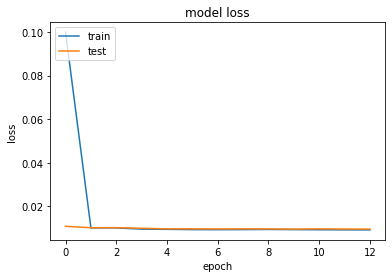

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()